 0. **Importing the libraries**
 1. **Plan**

- most important metric for our analysis is pace 
- Pace : distance / time ( 1 km run for how many minutes) exmple: 5:40 min/km 

- #### Possible first development: 

    - Sorting your running playlist according the pace predifined by your Garmin Coach feature (10k run training for example) 
    - how this pace distribution looks like and how is mapped to the 5 groups in our spotify playlist
         - let's try first with pace distribution from the analyzed run dataset    
    
 2. **Importing the dataset appying some data imputation and cleaning**

 3. **Getting familiar with the dataset**

- explore step by step the data set and see what we can do with it

- EDAs

- Relationships between features

 4. **Feature Extraction and Feature Engineering**

- Create KPI: pace
- Physical Workload ( heartrate/accending  ) 

5. **Define the Pace correlation with the music features**

- Pace bins : Clurster groups 

### 0. Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fitparse import FitFile
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import xyzservices.providers as xyz

### 2. Importing the dataset appying some data imputation and cleaning

In [34]:
# Load the FIT file
fitfile = FitFile('data/sofia_run.fit')

# Get all data messages that are of type record (the entries that contain the data)
records = []
for record in fitfile.get_messages('record'):
    r = {}
    for record_data in record:
        r[record_data.name] = record_data.value
    records.append(r)

# Convert to a pandas DataFrame
run_data = pd.DataFrame(records)

# save the dataframe to a csv file
run_data.to_csv('data/sofia_run.csv', index=False)


In [3]:
records

[{'cadence': 0,
  'distance': 0.61,
  'enhanced_altitude': 569.2,
  'enhanced_speed': 0.0,
  'fractional_cadence': 0.0,
  'heart_rate': 96,
  'position_lat': 509055056,
  'position_long': 278629435,
  'temperature': 25,
  'timestamp': datetime.datetime(2023, 5, 12, 17, 1, 35),
  'unknown_87': 0,
  'unknown_88': 300},
 {'cadence': 0,
  'distance': 1.34,
  'enhanced_altitude': 569.2,
  'enhanced_speed': 0.0,
  'fractional_cadence': 0.0,
  'heart_rate': 96,
  'position_lat': None,
  'position_long': None,
  'temperature': 25,
  'timestamp': datetime.datetime(2023, 5, 12, 17, 1, 36),
  'unknown_87': 0,
  'unknown_88': 100},
 {'cadence': 81,
  'distance': 1.34,
  'enhanced_altitude': 571.2,
  'enhanced_speed': 1.362,
  'fractional_cadence': 0.0,
  'heart_rate': 115,
  'position_lat': 509058505,
  'position_long': 278628557,
  'temperature': 25,
  'timestamp': datetime.datetime(2023, 5, 12, 17, 2, 5),
  'unknown_87': 0,
  'unknown_88': 100},
 {'cadence': 80,
  'distance': 2.45,
  'enhanced_a

In [48]:
run_data = pd.read_csv('data/sofia_run.csv')

In [49]:
run_data

,cadence,distance,enhanced_altitude,enhanced_speed,fractional_cadence,heart_rate,position_lat,position_long,temperature,timestamp,unknown_87,unknown_88,unknown_90
0,0,0.61,569.2,0.000,0.0,96,509055056.0,278629435.0,25,2023-05-12 17:01:35,0,300,NaN
1,0,1.34,569.2,0.000,0.0,96,NaN,NaN,25,2023-05-12 17:01:36,0,100,NaN
2,81,1.34,571.2,1.362,0.0,115,509058505.0,278628557.0,25,2023-05-12 17:02:05,0,100,NaN
3,80,2.45,571.4,1.362,0.0,113,509058665.0,278628408.0,25,2023-05-12 17:02:06,0,100,NaN
4,76,7.16,571.4,1.502,0.5,115,509058997.0,278627770.0,25,2023-05-12 17:02:09,0,100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,77,15985.33,579.4,2.015,0.5,129,509087690.0,278604787.0,20,2023-05-12 18:58:39,0,300,-3.0
1869,78,15986.45,579.2,1.959,0.0,128,509087068.0,278605096.0,20,2023-05-12 18:58:41,0,300,-3.0
1870,77,15995.16,579.2,1.885,0.5,128,509085871.0,278605970.0,20,2023-05-12 18:58:44,0,300,-3.0
1871,77,16002.08,579.0,1.913,0.5,128,509085485.0,278606442.0,20,2023-05-12 18:58:46,0,300,-3.0


### Our data set can be identified as Time series data

- Timeline or time series data refers to a sequence of data points indexed (or listed or graphed) in time order.
- Snapshots of information is taken at approximately 2-3 seconds intervals

We can set the index of our data frame to be the timestamp column
That would give us: 
1. **Efficient Time-based Indexing**: Setting the timestamp as the index allows for efficient time-based indexing and slicing.
2. **Resampling**: With a timestamp index, you can easily resample your data. minute/hour summaries
3. **Time-based Operations**: Compute rolling statistics (like a 7-day rolling average of pace or heart rate)

- the change in position has been recorded as well. We can try visualize the running trace on a map with (geopandas)

In [50]:
run_data.timestamp = pd.to_datetime(run_data.timestamp)

In [51]:
run_data.set_index('timestamp', inplace=True)

Let's exlore not familiar features and see what we can do with them
- first data types of the features
- second missing values and fast statistics

In [52]:
run_data.dtypes

cadence                 int64
distance              float64
enhanced_altitude     float64
enhanced_speed        float64
fractional_cadence    float64
heart_rate              int64
position_lat          float64
position_long         float64
temperature             int64
unknown_87              int64
unknown_88              int64
unknown_90            float64
dtype: object

In [53]:
run_data.describe()

,cadence,distance,enhanced_altitude,enhanced_speed,fractional_cadence,heart_rate,position_lat,position_long,temperature,unknown_87,unknown_88,unknown_90
count,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1.859000e+03,1.859000e+03,1873.000000,1873.0,1873.000000,1539.000000
mean,73.791244,7962.773903,584.117779,2.281573,0.171650,136.739455,5.090669e+08,2.782431e+08,18.555793,0.0,182.861719,-0.866147
std,13.962583,4576.077050,18.504732,0.459504,0.237469,11.877690,9.580174e+04,1.817043e+05,1.486840,0.0,98.546762,0.724109
min,0.000000,0.610000,545.200000,0.000000,0.000000,86.000000,5.089248e+08,2.780230e+08,16.000000,0.0,100.000000,-3.000000
25%,76.000000,3915.330000,574.200000,2.090000,0.000000,131.000000,5.089822e+08,2.780976e+08,18.000000,0.0,100.000000,-1.000000
50%,78.000000,8322.760000,582.800000,2.379000,0.000000,137.000000,5.090464e+08,2.781476e+08,18.000000,0.0,100.000000,-1.000000
75%,79.000000,11636.760000,599.000000,2.594000,0.500000,143.000000,5.091332e+08,2.784033e+08,19.000000,0.0,300.000000,0.000000
max,84.000000,16006.890000,618.000000,3.098000,0.500000,165.000000,5.092669e+08,2.786294e+08,25.000000,0.0,300.000000,0.000000


In [54]:
run_data.unknown_87.unique()
run_data.unknown_88.unique()
run_data.unknown_90.unique()

array([nan, -1., -2.,  0., -3.])

- uknown_** columns are not needed an we are going to drop them

In [55]:
run_data = run_data.drop(['unknown_87', 'unknown_88', 'unknown_90'], axis=1)

- check for missing values

In [56]:
run_data.isna().sum()

cadence                0
distance               0
enhanced_altitude      0
enhanced_speed         0
fractional_cadence     0
heart_rate             0
position_lat          14
position_long         14
temperature            0
dtype: int64

- we have 2 columns with 14 missing values each. 
- It is the geospatial data (latitude and longitude)
- We will keep them for now and drop them only when we a constructing the map 

In [41]:
run_data.to_csv('data/run_data.csv', index=True)

### 3. Getting familiar with the dataset

- Graph all the features and see how they look like in time

In [42]:
run_data

,cadence,distance,enhanced_altitude,enhanced_speed,heart_rate,position_lat,position_long,temperature,timestamp
0,0,0.61,569.2,0.000,96,509055056.0,278629435.0,25,2023-05-12 17:01:35
1,0,1.34,569.2,0.000,96,NaN,NaN,25,2023-05-12 17:01:36
2,81,1.34,571.2,1.362,115,509058505.0,278628557.0,25,2023-05-12 17:02:05
3,80,2.45,571.4,1.362,113,509058665.0,278628408.0,25,2023-05-12 17:02:06
4,76,7.16,571.4,1.502,115,509058997.0,278627770.0,25,2023-05-12 17:02:09
...,...,...,...,...,...,...,...,...,...
1868,77,15985.33,579.4,2.015,129,509087690.0,278604787.0,20,2023-05-12 18:58:39
1869,78,15986.45,579.2,1.959,128,509087068.0,278605096.0,20,2023-05-12 18:58:41
1870,77,15995.16,579.2,1.885,128,509085871.0,278605970.0,20,2023-05-12 18:58:44
1871,77,16002.08,579.0,1.913,128,509085485.0,278606442.0,20,2023-05-12 18:58:46


In [57]:
run_data.index

DatetimeIndex(['2023-05-12 17:01:35', '2023-05-12 17:01:36',
               '2023-05-12 17:02:05', '2023-05-12 17:02:06',
               '2023-05-12 17:02:09', '2023-05-12 17:02:10',
               '2023-05-12 17:02:12', '2023-05-12 17:02:16',
               '2023-05-12 17:02:20', '2023-05-12 17:02:23',
               ...
               '2023-05-12 18:58:22', '2023-05-12 18:58:28',
               '2023-05-12 18:58:31', '2023-05-12 18:58:34',
               '2023-05-12 18:58:36', '2023-05-12 18:58:39',
               '2023-05-12 18:58:41', '2023-05-12 18:58:44',
               '2023-05-12 18:58:46', '2023-05-12 18:58:48'],
              dtype='datetime64[ns]', name='timestamp', length=1873, freq=None)

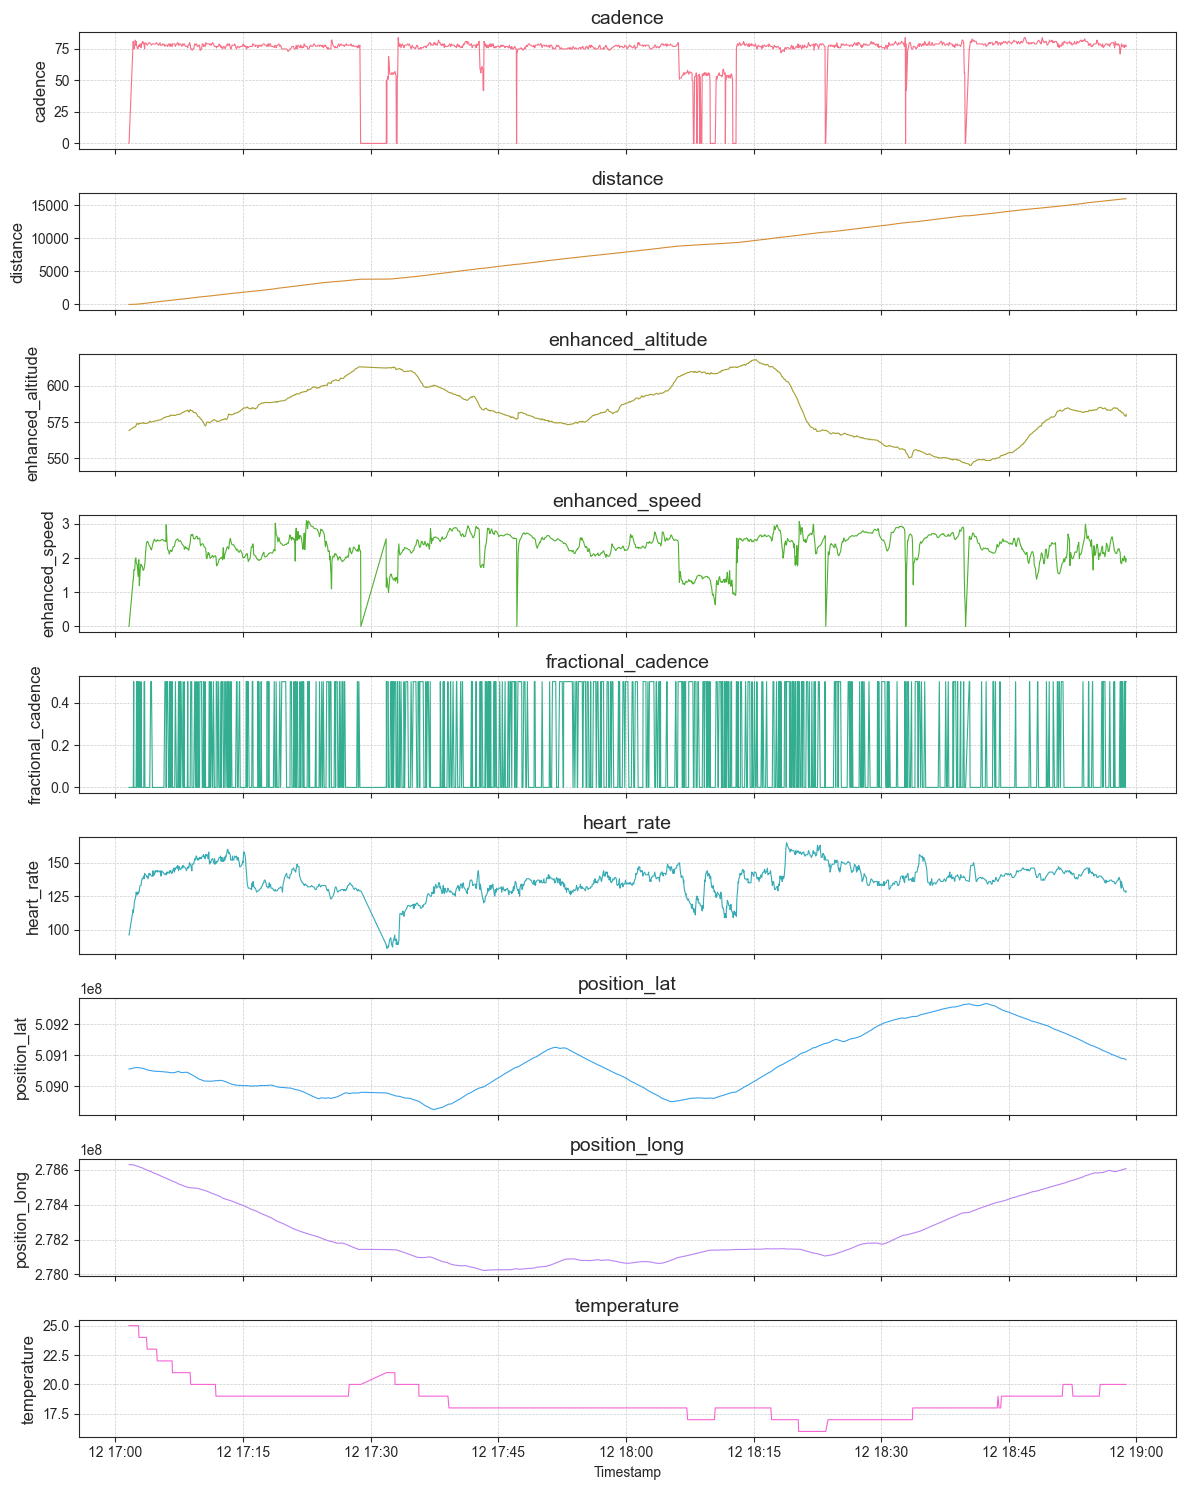

In [58]:
# Set Seaborn theme
sns.set_style("ticks")

# Setting the figure size and layout
fig, axes = plt.subplots(nrows=len(run_data.columns), figsize=(12, 15), sharex=True)

# Generating a color palette with a distinct color for each feature
palette = sns.color_palette("husl", n_colors=len(run_data.columns))

# Plotting each feature using Seaborn with distinct colors
for ax, (feature, color) in zip(axes, zip(run_data.columns, palette)):
    sns.lineplot(data=run_data, x=run_data.index, y=feature, ax=ax, color=color, linewidth=0.8)
    ax.set_title(feature, fontsize=14)
    ax.set_ylabel(feature, fontsize=12)
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    # break

plt.tight_layout()
plt.xlabel('Timestamp')
plt.show()


- fractional cadence is not giving us any information and we are going to drop it
- position lat and long visualized in this format are not giving us any information also 

In [59]:
run_data.drop("fractional_cadence", axis=1, inplace=True)

In [60]:
run_data_nogeo = run_data.drop(['position_lat', 'position_long'], axis=1)

### Device accuracy
- Wanted to see on what intervals the device is recording the data
- does it have a constant interval or it is changing

### Relationships between features

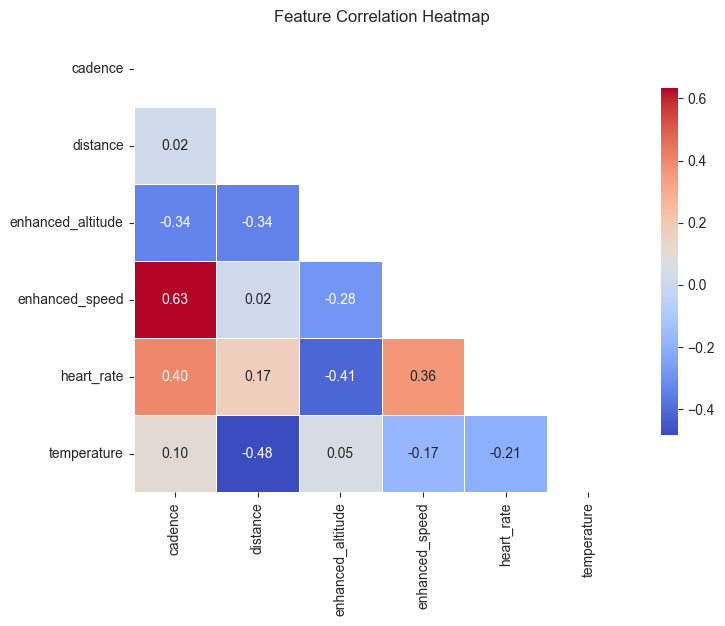

In [61]:
# Calculate the correlation matrix
corr = run_data_nogeo.corr()

# Set up the mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Generate the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5, cbar_kws={"shrink": 0.75})

# Title for the heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

### Scatter Plot of relationship between features in timeseries data will not give us any usefull insight

Let's try with timeseries oriented metrics like rolling mean and rolling standard deviation
- it will smooth the data especially the cadence jagged line
- The rolling standard deviation gives an idea about the variability in the data over the specified window.

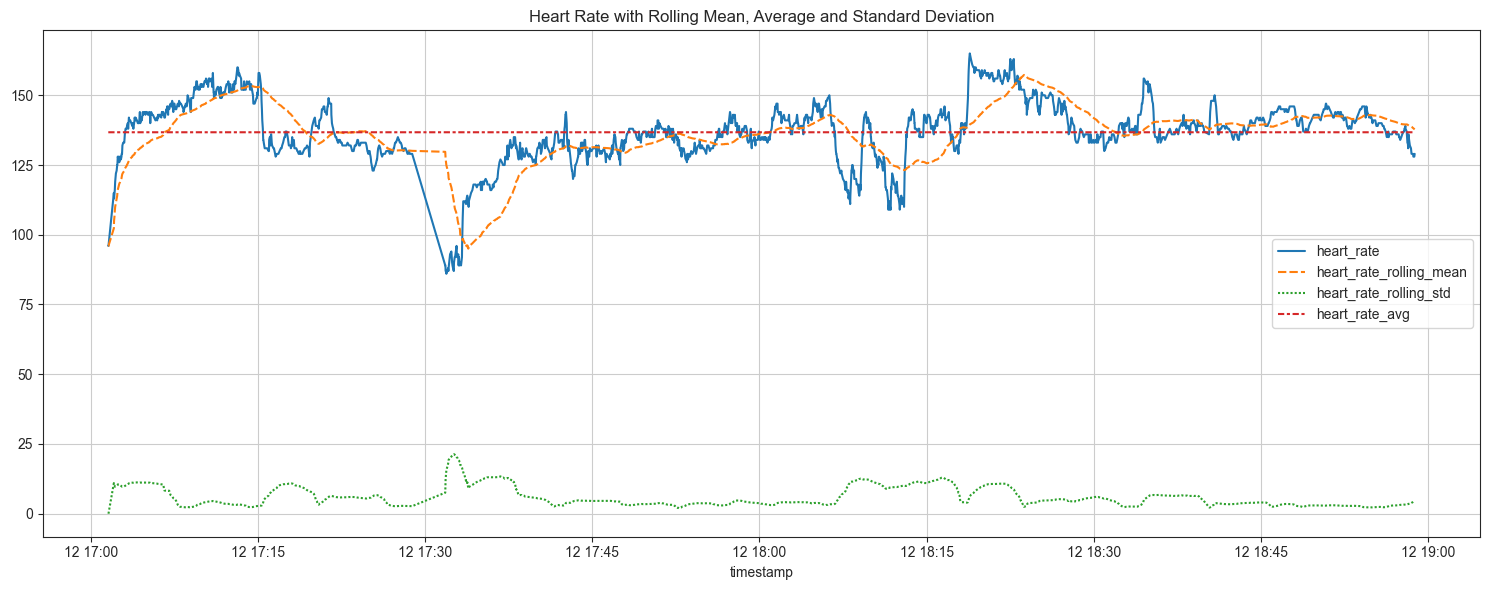

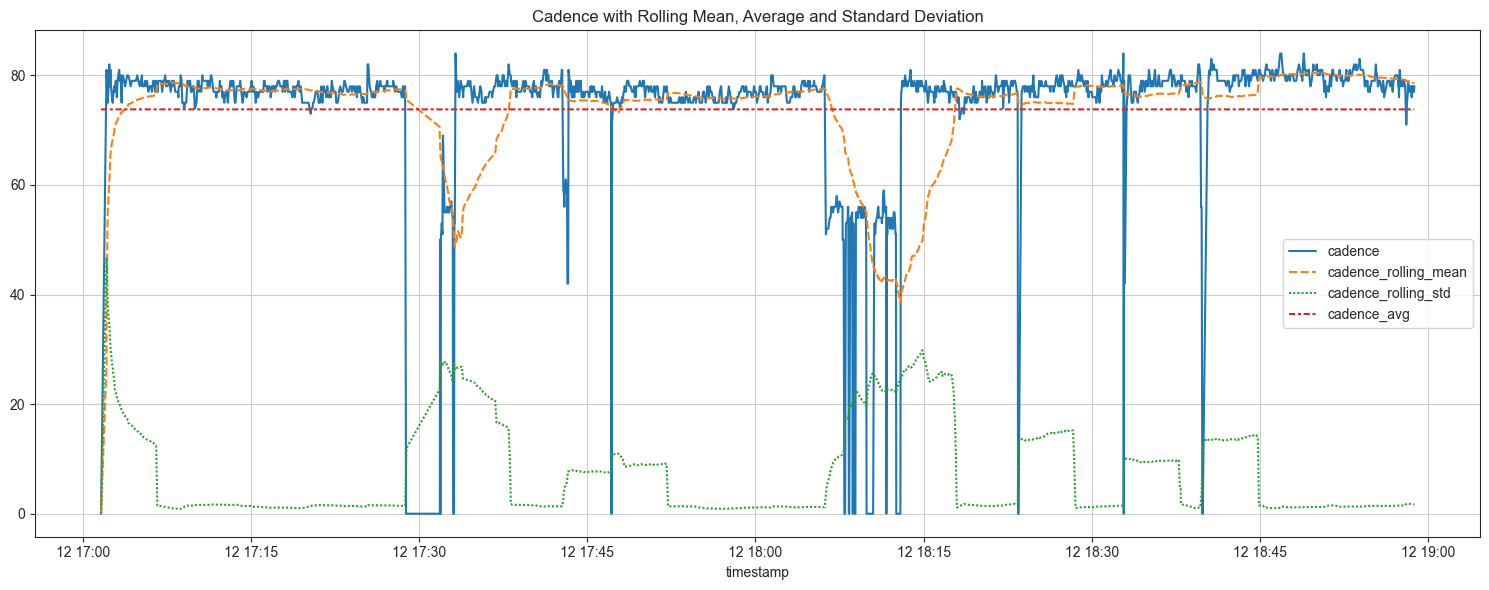

In [62]:
# Define the rolling window size
window_size = '5T'  # 5 minutes

# Compute the overall average for heart_rate and cadence
run_data_nogeo['heart_rate_avg'] = run_data_nogeo['heart_rate'].mean()
run_data_nogeo['cadence_avg'] = run_data_nogeo['cadence'].mean()


# Compute the rolling mean and standard deviation for heart_rate and cadence
run_data_nogeo['heart_rate_rolling_mean'] = run_data_nogeo['heart_rate'].rolling(window=window_size).mean()
run_data_nogeo['heart_rate_rolling_std'] = run_data_nogeo['heart_rate'].rolling(window=window_size).std()

run_data_nogeo['cadence_rolling_mean'] = run_data_nogeo['cadence'].rolling(window=window_size).mean()
run_data_nogeo['cadence_rolling_std'] = run_data_nogeo['cadence'].rolling(window=window_size).std()

# Plotting the rolling mean, overall average, and standard deviation for heart_rate
plt.figure(figsize=(15, 6))
sns.lineplot(data=run_data_nogeo[['heart_rate', 'heart_rate_rolling_mean', 'heart_rate_rolling_std', 'heart_rate_avg']], palette="tab10")
plt.title('Heart Rate with Rolling Mean, Average and Standard Deviation')
# plt.legend(['Heart Rate', 'Rolling Mean', 'Rolling Standard Deviation', 'Overall Average'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting the rolling mean, overall average, and standard deviation for cadence
plt.figure(figsize=(15, 6))
sns.lineplot(data=run_data_nogeo[['cadence', 'cadence_rolling_mean', 'cadence_rolling_std', 'cadence_avg']], palette="tab10")
plt.title('Cadence with Rolling Mean, Average and Standard Deviation')
# plt.legend(['Cadence', 'Rolling Mean', 'Rolling Standard Deviation', 'Overall Average'])
plt.grid(True)
plt.tight_layout()
plt.show()


# Let's explore cross correlation between those features
- Cross-correlation measures the similarity between two time series as a function of the time lag applied to one of them.

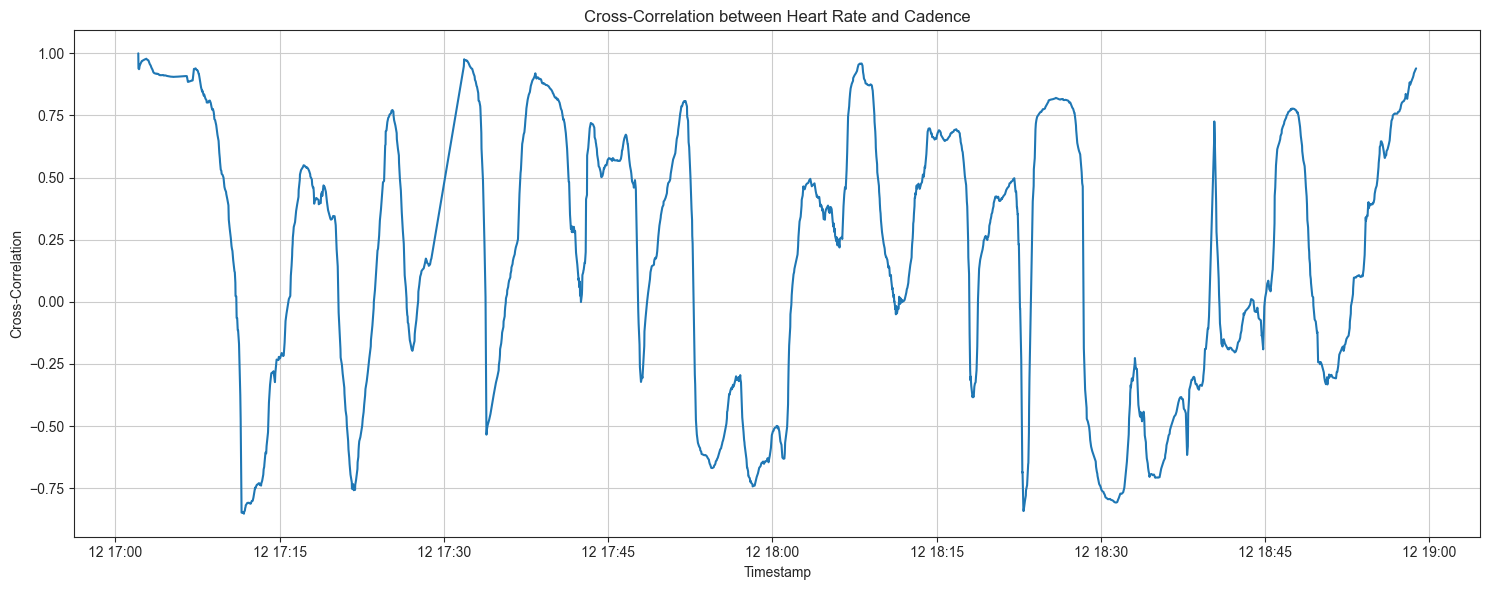

In [68]:
# Compute the cross-correlation between heart_rate and cadence
cross_corr = run_data_nogeo['heart_rate'].rolling(window=window_size).corr(run_data_nogeo['cadence_rolling_mean'])

# Plot the cross-correlation
plt.figure(figsize=(15, 6))
sns.lineplot(data=cross_corr)
plt.title('Cross-Correlation between Heart Rate and Cadence')
plt.xlabel('Timestamp')
plt.ylabel('Cross-Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()


### Visualizing the running trace on a map

In [22]:
ctx.providers.keys()
ctx.providers.Strava.Run

{'url': 'https://heatmap-external-a.strava.com/tiles/run/bluered/{z}/{x}/{y}.png',
 'max_zoom': 15,
 'attribution': 'Map tiles by <a href="https://labs.strava.com/heatmap">Strava 2021</a>',
 'html_attribution': 'Map tiles by <a href="https://labs.strava.com/heatmap">Strava 2021</a>',
 'name': 'Strava.Run'}

In [23]:
ctx.providers.keys()
ctx.providers.OpenStreetMap.keys()
ctx.providers.OpenStreetMap.BlackAndWhite

{'url': 'http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png',
 'max_zoom': 18,
 'attribution': '(C) OpenStreetMap contributors',
 'html_attribution': '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
 'name': 'OpenStreetMap.BlackAndWhite'}

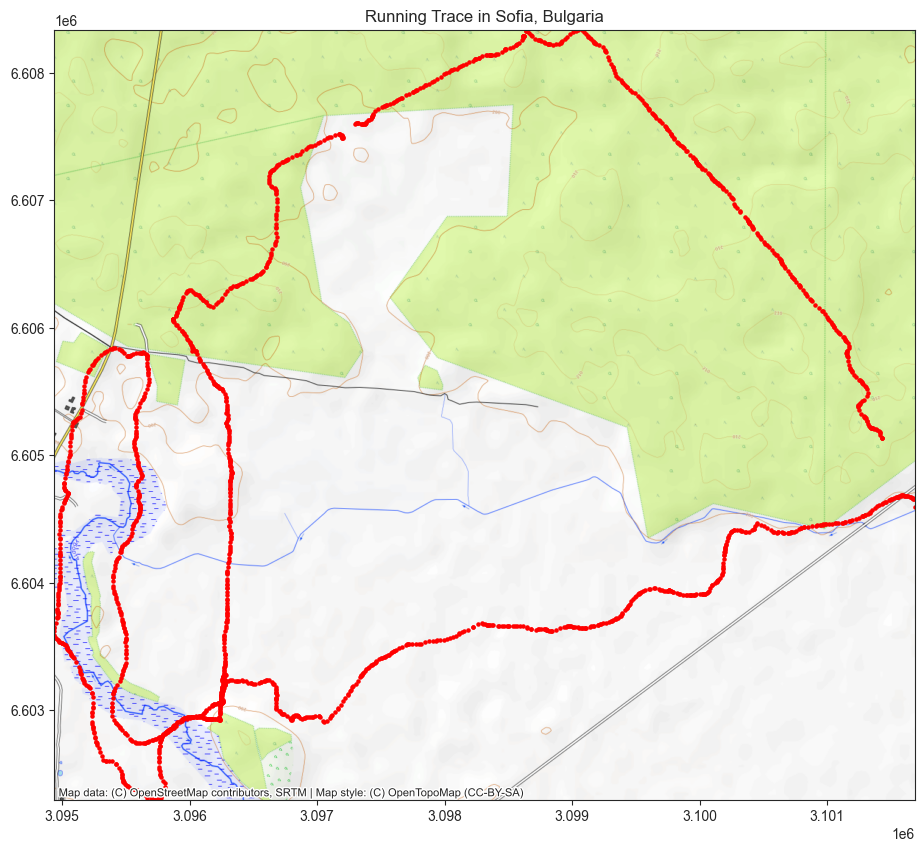

In [24]:

# Drop rows with missing latitude or longitude
run_data_clean = run_data.dropna(subset=['position_lat', 'position_long'])

# Create a new geometry column from the normalized longitude and latitude
geometry = [Point(xy) for xy in zip(run_data_clean['position_long'] / 1e7, run_data_clean['position_lat'] / 1e7)]

# Convert to a GeoDataFrame
geo_run_data = gpd.GeoDataFrame(run_data_clean, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84
geo_run_data.crs = "EPSG:4326"

# Convert the data to Web Mercator for use with contextily
geo_run_data = geo_run_data.to_crs(epsg=3857)

# Get the bounding box of the data
minx, miny, maxx, maxy = geo_run_data.geometry.total_bounds

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
geo_run_data.plot(ax=ax, markersize=5, color='red')
ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_title("Running Trace in Sofia, Bulgaria")

plt.show()


### 4. Feature Extraction and Feature Engineering

- Create KPI: Pace in min/km

In [72]:
resampled_data['distance'].diff().head(2), resampled_data['distance'].head(2)


(timestamp
 2023-05-12 17:01:00      NaN
 2023-05-12 17:02:00    80.43
 Freq: T, Name: distance, dtype: float64,
 timestamp
 2023-05-12 17:01:00     1.34
 2023-05-12 17:02:00    81.77
 Freq: T, Name: distance, dtype: float64)

In [73]:
# Resample the dataset at 1-minute intervals and compute the cumulative distance at each interval
resampled_data = run_data_nogeo.resample('1T').last()

# Calculate the distance traveled in each 1-minute interval
resampled_data['distance_diff'] = resampled_data['distance'].diff()

# Convert distance from meters to kilometers
resampled_data['distance_diff_km'] = resampled_data['distance_diff'] / 1000

# Compute the speed in km/h for each interval
resampled_data['speed_km_h'] = resampled_data['distance_diff_km'] * 60  # since there are 60 minutes in an hour

# Display the speed values in km/h
resampled_speed = resampled_data[['speed_km_h']]
resampled_speed.tail(20)


,speed_km_h
timestamp,
2023-05-12 18:39:00,7.2828
2023-05-12 18:40:00,5.8524
2023-05-12 18:41:00,7.4646
2023-05-12 18:42:00,8.4756
2023-05-12 18:43:00,9.2832
2023-05-12 18:44:00,8.3730
2023-05-12 18:45:00,9.0120
2023-05-12 18:46:00,8.3838
2023-05-12 18:47:00,8.6334


#### Now we can easily convert that into pace in min/km

In [74]:
# Convert speed in km/h to pace in min/km
resampled_data['pace_min_km'] = 60 / resampled_data['speed_km_h']

# Display the pace values in min/km
resampled_pace = resampled_data[['pace_min_km']]
resampled_pace.tail(20)


,pace_min_km
timestamp,
2023-05-12 18:39:00,8.238590
2023-05-12 18:40:00,10.252204
2023-05-12 18:41:00,8.037939
2023-05-12 18:42:00,7.079145
2023-05-12 18:43:00,6.463289
2023-05-12 18:44:00,7.165890
2023-05-12 18:45:00,6.657790
2023-05-12 18:46:00,7.156659
2023-05-12 18:47:00,6.949753


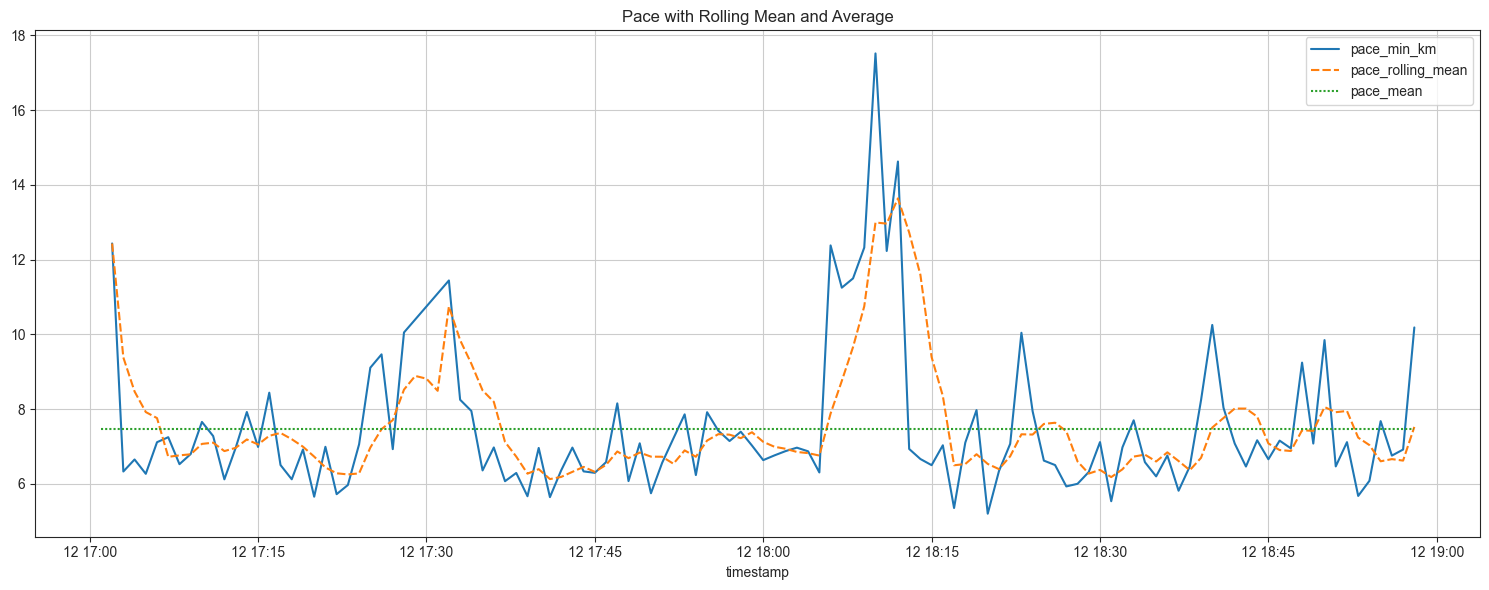

In [75]:
window_size = '5T'  # 5 minutes
resampled_data["pace_rolling_mean"] = resampled_pace.rolling(window=window_size).mean()
resampled_data["pace_mean"] = round(resampled_pace.mean(), 2)[0]
plt.figure(figsize=(15, 6))
sns.lineplot(data=resampled_data[['pace_min_km', 'pace_rolling_mean', 'pace_mean']], palette="tab10")
plt.title('Pace with Rolling Mean and Average')
plt.grid(True)
plt.tight_layout()
plt.show()

### 5. **Define the Pace correlation with the music features**